# Problem 1: Unimodal Gaussian Distribution
First, we create our target Gaussian distribution.

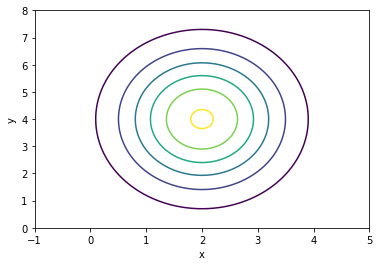

In [2]:
import os
os.chdir("../")
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.GaussianLogPDF([2, 4], [[1, 0], [0, 3]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-1, 5, num_points)
y = np.linspace(-0, 8, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now we set up a sampling routine using Slice Sampling with Rank Shrinking.

In [3]:
# Choose starting point for 3 mcmc chains
xs = [
    [2, 4],
    [3, 3],
    [5, 4],
]

# Create mcmc routine
mcmc = pints.MCMCController(log_pdf, 3, xs, method=pints.SliceRankShrinkingMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

In [6]:
for sampler in mcmc.samplers():
    sampler.set_sigma_c(2)
    
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Covariance-Adaptive: Rank Shrinking.
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     9       0:00.1
1     15      0:00.1
2     21      0:00.1
3     27      0:00.1
1000  7287    0:02.7
2000  14301   0:05.2
Halting: Maximum number of iterations (2000) reached.
Done!


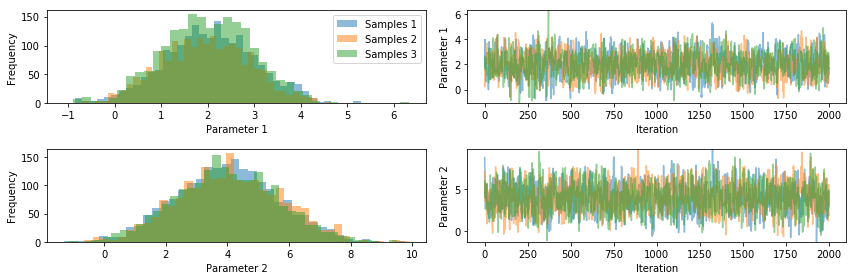

In [7]:
# Show traces and histograms
import pints.plot
pints.plot.trace(full_chains)
plt.show()

In [8]:
# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(full_chains))

R-hat:
[1.0012184639640043, 1.0007746660425314]


In [9]:
chain = full_chains[0]

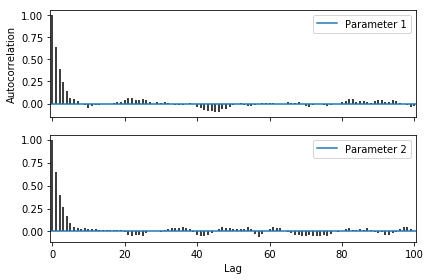

In [10]:
pints.plot.autocorrelation(chain)
plt.show()

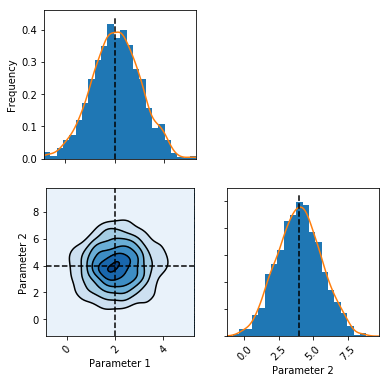

In [11]:
pints.plot.pairwise(chain, kde=True, ref_parameters=[2,4])
plt.show()

# Problem 2: Multimodal Distribution

Having the confidence that Slice Sampling with Rank Shrinking performs well on a simple unimodal Gaussian distribution, we check its performance on a more problematic multimodal exercise.

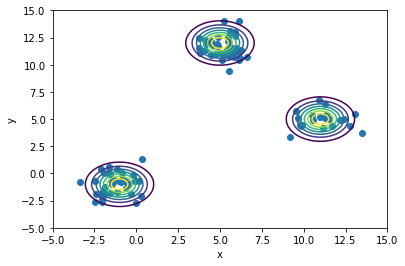

In [13]:
log_pdf = pints.toy.MultimodalGaussianLogPDF(modes=[[-1, -1], [11, 5], [5, 12]])

samples = log_pdf.sample(100)

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [15]:
# Create an adaptive covariance MCMC routine
x0 = np.random.uniform([2, 2], [8, 8], size=(4, 2))
mcmc = pints.MCMCController(log_pdf, 4, x0, method=pints.SliceRankShrinkingMCMC)

for sampler in mcmc.samplers():
    sampler.set_sigma_c(10)

# Set maximum number of iterations
mcmc.set_max_iterations(2000)

# Disable logging
mcmc.set_log_to_screen(False)

# Number of chains
num_chains = 4

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...


/Users/lorcandelaney/Desktop/rank-shrinking/pints/pints/toy/_multimodal_gaussian.py:115: RuntimeWarning: invalid value encountered in true_divide
  return L, -numer / denom


Done!


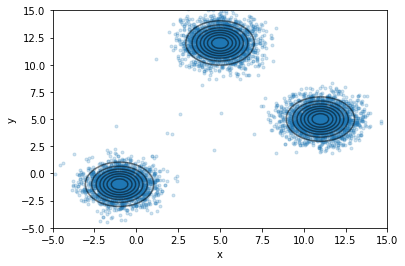

In [16]:
stacked = np.vstack(chains)
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [17]:
print("KL divergence by mode: " + str(log_pdf.kl_divergence(stacked)))

KL divergence by mode: [0.00097349 0.00784842 0.00176786]


# Problem 3: Time-Series Problem - Logistic Model
We now try the same method on a more realistic time-series problem using a logistic model, following the tutorial notebook: [sampling-first-example](./sampling-first-example.ipynb).

In [22]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

class ExampleModel(pints.ForwardModel):
    
    def __init__(self):
        self.model = toy.LogisticModel()
    def simulate(self, x, times):
        return self.model.simulate([x[0]/1000, x[1]], times)
    def simulateS1(self, x, times):
        values, gradient = self.model.simulateS1([x[0]/1000, x[1]], times)
        return values, gradient
    def n_parameters(self):
        return 2


# Then create an instance of our new model class
model = ExampleModel()

In [36]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Create some toy data
real_parameters = [0.015*10000, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01*10000, 400, noise * 0.1],
    [0.02*10000, 600, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
num_chains = 3
xs = [
    real_parameters * 1.01,
    real_parameters * 0.99,
    real_parameters * 1.01,
]

# Create mcmc routine
mcmc = pints.MCMCController(
    log_posterior, num_chains, xs, method=pints.SliceRankShrinkingMCMC)

for sampler in mcmc.samplers():
    sampler.set_sigma_c(0.5)
    
# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling - Covariance-Adaptive: Rank Shrinking.
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     24      0:00.0
2     27      0:00.0
3     42      0:00.0
1000  13179   0:06.4
2000  25931   0:12.4
Halting: Maximum number of iterations (2000) reached.
Done!


R-hat:
[1.0089417595913814, 1.0002507419251023, 1.00019012062283]


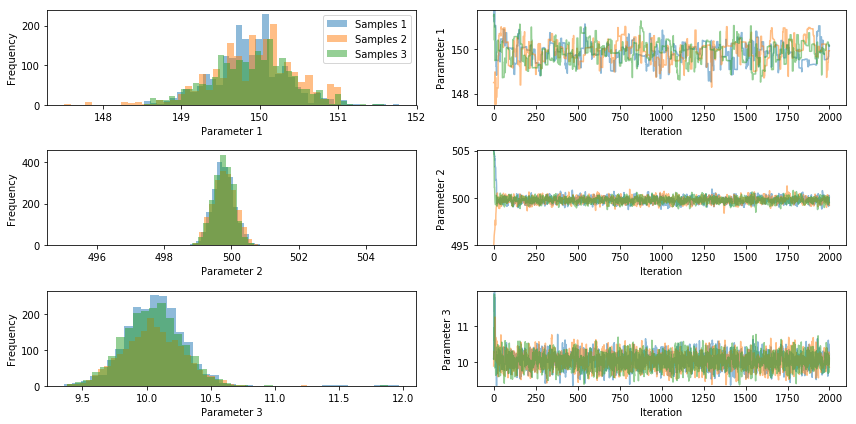

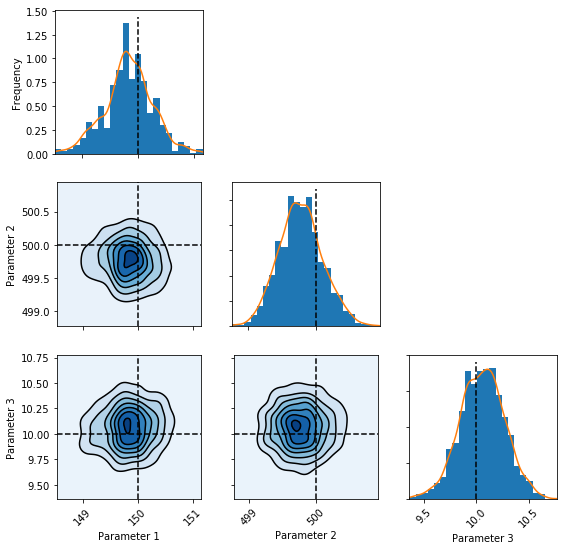

In [37]:
# Show traces and histograms
pints.plot.trace(full_chains)

# Discard warm up
full_chains = full_chains[:, 200:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(full_chains))

# Look at distribution in chain 0
pints.plot.pairwise(full_chains[0], kde=True, ref_parameters = real_parameters)

# Show graphs
plt.show()